# Analyzing "Bitcoin OTC trust weighted signed network"

The original dataset was retrieved via the SNAP webpage http://snap.stanford.edu/data/soc-sign-bitcoin-otc.html and can be downloaded there for full reproducability. 

The network is basically a network in which users (nodes) can indicate how much they trust other users on the Bitcoin OTC  platform. They do so by assigning ratings (-10 to +10, indicating distrusting entirely and trusting entirely respectively). 

References: 

S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. Edge Weight Prediction in Weighted Signed Networks. IEEE International Conference on Data Mining (ICDM), 2016. [http://css.stanford.edu/~srijan/pubs/wsn-icdm16.pdf]

S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. REV2: Fraudulent User Prediction in Rating Platforms. 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018. [http://css.stanford.edu/~srijan/pubs/rev2-wsdm18.pdf] 

# 0: Loading necessary modules

In [2]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime
from itertools import repeat

# Loading the dataset and creating a neo4j aura session

In [4]:
# path to file is of course user-sepecific
node_network = pd.read_csv('C:/Users/Jasper/Downloads/soc-sign-bitcoinotc.csv', header=None)
node_network.columns = ['SOURCE', 'TARGET', 'RATING', 'TIME']
node_network

,SOURCE,TARGET,RATING,TIME
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


In [5]:
# Once this is done, we can transform the time 

def epoch_to_time_stamp(epoch):
    val = datetime.fromtimestamp(epoch)
    return val

node_network['Date'] = node_network['TIME'].apply(epoch_to_time_stamp)

In [6]:
node_network

,SOURCE,TARGET,RATING,TIME,Date
0,6,2,4,1.289242e+09,2010-11-08 19:45:11.728360
1,6,5,2,1.289242e+09,2010-11-08 19:45:41.533780
2,1,15,1,1.289243e+09,2010-11-08 20:05:40.390490
3,4,3,7,1.289245e+09,2010-11-08 20:41:17.369750
4,13,16,8,1.289254e+09,2010-11-08 23:10:54.447460
...,...,...,...,...,...
35587,4499,1810,1,1.453612e+09,2016-01-24 06:14:41.647290
35588,2731,3901,5,1.453679e+09,2016-01-25 00:50:28.049490
35589,2731,4897,5,1.453679e+09,2016-01-25 00:50:34.034020
35590,13,1128,1,1.453680e+09,2016-01-25 00:53:52.985710


# Creating the Neo4j Sandbox Session

In [7]:
# As I am using a sandbox session, those login credentials are due to change and specific to session

uri = "bolt://ww.xxx.yyy.zzz:7687"
user = "neo4j"
password = "random-password-generated"

driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

In [8]:
# In case there is anything left, let us clear everything
session.run("MATCH (n) DETACH DELETE n")

# 1. Exploratory Data Analysis, Basic Statistics

##  1.1 Let's do a bit of exploratory data analysis and basic statistics

In [9]:
# How many players are there in total? 
nodeset = set(node_network['SOURCE']).union(set(node_network['TARGET']))
print(len(nodeset))

5881


In [10]:
# And how many relationships are there? 
print(node_network.shape[0])

35592


In [11]:
# What is the sum of all ratings? 
node_network['RATING'].sum()

36020

Already here, it is interesting to see that the sum of the ratings is almost equal to the number of relationships. Thus, we should expect a lot of ratings around 1 (meaning: very weakly positive trust).

In [12]:
# Let's back this up numerically.
print(node_network['RATING'].mean())

1.0120251741964486


## 1.2 Visual Exploration

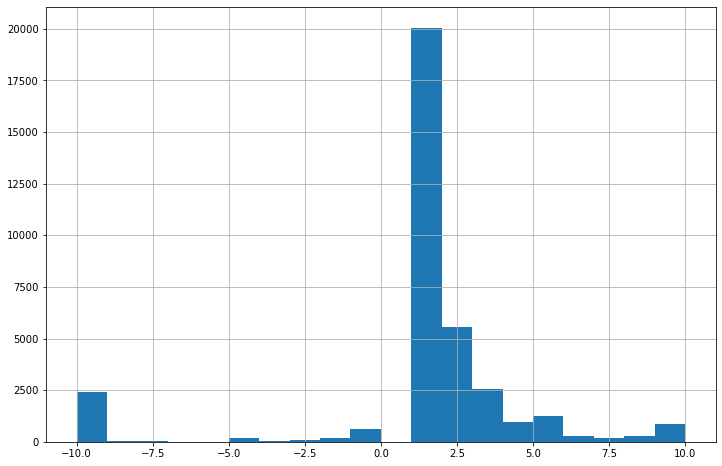

In [13]:
# Let us explore the ratings visually
plt.figure(figsize=(12,8))
node_network['RATING'].hist(bins=20)

As expected, there is a large peak at 1. Also, we see a bit of "weak trust" in the range 2-5. Next to that, it is interesting to see how the distribution has small peaks around -10 and 10. 

Also, note how few ratings occur at the (-9,0) range. Apparently, if bad ratings occur, they occur at the 'total distrusts' space.

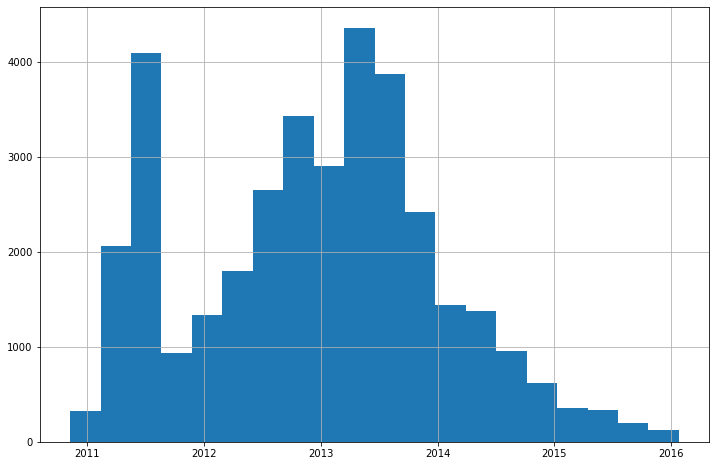

In [14]:
plt.figure(figsize=(12,8))
node_network['Date'].hist(bins=20)

An analysis of the time, i.e., the time when ratings occurred is also interesting. An increase in the number of ratings is seen in the first half of 2011. After that, it dropped sharply. In the beginning of 2012 it picked up again, had its peak around summer of 2013 and has decreased ever since. 

Regarding a possible explanation, it could be that the network of trust has established already or that the 'technological headstart' that the incumbents have is too much to pick up for newcomers. 

# 2: Writing nodes and relationships into the neo4j database instance. 

In [15]:
# Writing nodes
for elem in nodeset:
    session.run("CREATE (a:Node {id: '" + str(elem) + "'})")

In [16]:
# Writing relationships - we specify a directed relationship and store rating and time as 
# edge properties

for i in range(node_network.shape[0]):
    source = node_network['SOURCE'].iloc[i]
    target = node_network['TARGET'].iloc[i]
    rating = node_network['RATING'].iloc[i]
    time = node_network['TIME'].iloc[i]

    a = "MATCH (a:Node {id: '" + str(source) + "'}) "
    b = "MATCH (b:Node {id: '" + str(target) + "'}) "
    c = "MERGE (a)-[r:TRUSTS]->(b) "
    d = "SET r.rating = " + str(rating)
    e = " SET r.time = " + str(time)

    f = a + b + c + d + e

    session.run(f)

    if i % 5000 == 0:
        print(i)

0
5000
10000
15000
20000
25000
30000
35000


# 3: Analysis on the graph

In [17]:
# Let's find the 10 most trusted nodes
# We rely on the sum instead of the mean rating as being trusted a little by a lot of other nodes
# is more informative than being trusted a lot by a few nodes

top10_query = """
MATCH (a)-[r:TRUSTS]->(b) 
RETURN b.id, SUM(r.rating) AS COMPOUND
ORDER BY COMPOUND DESC
LIMIT 10 
"""

result = session.run(top10_query).values()

In [18]:
top10 = pd.DataFrame(result)
top10.columns = ['id', 'Score']
top10

,id,Score
0,2642,1041
1,35,1016
2,1,801
3,7,614
4,4172,472
5,1018,471
6,2125,439
7,4197,416
8,4291,360
9,13,341


So, the nodes with id 2642, 35, 1, 6, and 4172 are apparently highly trustful.

In [19]:
# What about the worst ones?
bottom10_query = """
MATCH (a)-[r:TRUSTS]->(b)
RETURN b.id, SUM(r.rating) AS COMPOUND
ORDER BY COMPOUND ASC
LIMIT 10
"""

with driver.session() as sesison:
    result = session.run(bottom10_query).values()
    session.close()

In [20]:
bottom10 = pd.DataFrame(result)
bottom10.columns = ['id', 'Score']
bottom10

,id,Score
0,3744,-675
1,2498,-256
2,1383,-232
3,4531,-230
4,2017,-229
5,4654,-186
6,4744,-179
7,4681,-176
8,4672,-169
9,4686,-167


Also, the nodes with id 3744, 2498, 1383, 4531, and 2017 are apparently highly distrustful.

## 3.1 Let's look at difference between in-degrees and out-degrees

In [21]:
query = """
MATCH (a)
RETURN a.id, apoc.node.degree.in(a) AS in_degree, apoc.node.degree.out(a) AS out_degree
"""

results = session.run(query).values()

In [22]:
ins_outs_df = pd.DataFrame(results)
ins_outs_df.columns = ['Node', 'inDegree', 'outDegree']

In [23]:
ins_outs_df

,Node,inDegree,outDegree
0,1,226,215
1,2,41,45
2,3,21,0
3,4,54,63
4,5,3,3
...,...,...,...
5876,6000,0,1
5877,6002,1,0
5878,6003,1,0
5879,6004,1,0


In [24]:
print(max(ins_outs_df['outDegree']))
print(max(ins_outs_df['inDegree']))

763
535


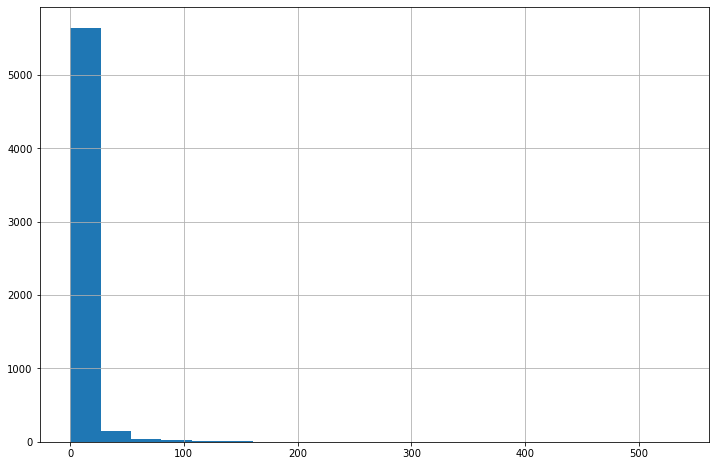

In [25]:
plt.figure(figsize=(12,8))
ins_outs_df['inDegree'].hist(bins=20)

Very skewed. A lot with a few, and only a handful of nodes with more than 100 (however, up to 535).

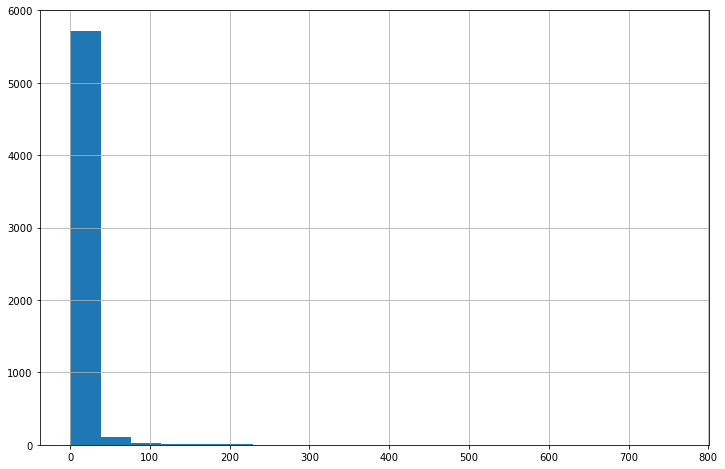

In [26]:
plt.figure(figsize=(12,8))
ins_outs_df['outDegree'].hist(bins=20)

Basically the same story. The only difference being that the out-degrees go up to 763.

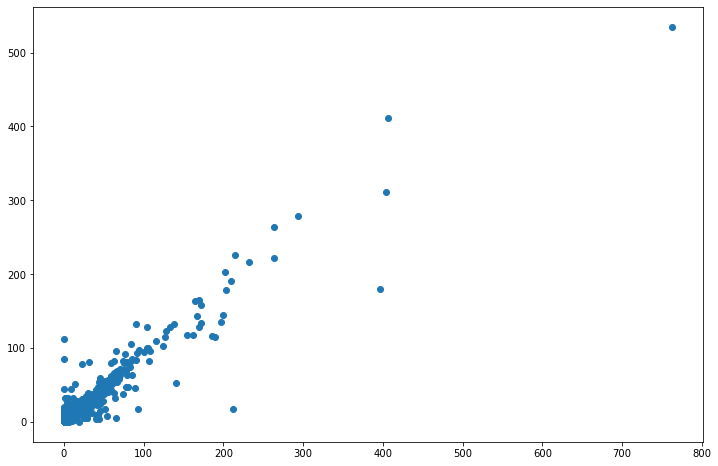

In [27]:
# Let us have a look at the correlation between in-degree and out-degree
plt.figure(figsize=(12,8))
plt.scatter(x=ins_outs_df['outDegree'], y=ins_outs_df['inDegree'])

It seems to be the case that there is a positive correlation, i.e., a high in-degree leading to a high out-degree.
However, that could be skewed because the data is very cluttered around the two (0-100) ranges. So, let's zoom in a bit.

(0.0, 100.0)

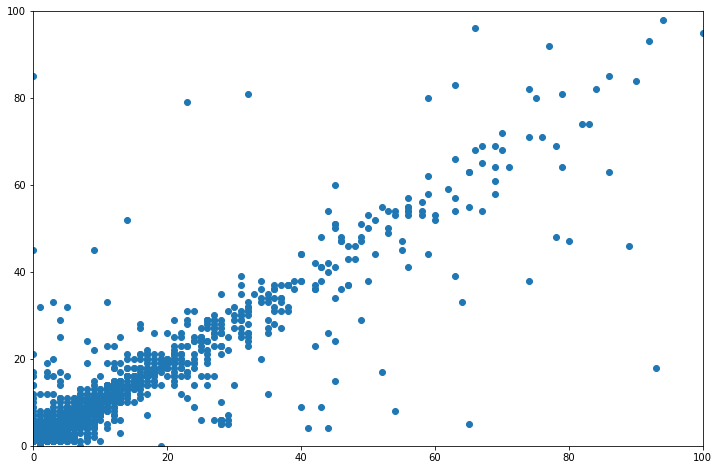

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(x=ins_outs_df['outDegree'], 
           y=ins_outs_df['inDegree'])

plt.xlim(0, 100)
plt.ylim(0, 100)

This confirms it.

In [29]:
# Let's look again at the top nodes.
query = """
MATCH (a)-[r:TRUSTS]->(b)
WITH  a, count(r) AS outs
ORDER BY outs DESC
LIMIT 10
WITH a, outs
MATCH (c)-[r2:TRUSTS]->(a)
RETURN outs, count(r2) AS ins, a.id as node
"""

results = session.run(query).values()

In [30]:
outs_ins = pd.DataFrame(results)
outs_ins.columns = ['OutDegree', 'InDegree', 'NodeId']
outs_ins

,OutDegree,InDegree,NodeId
0,763,535,35
1,406,412,2642
2,404,311,1810
3,397,180,2125
4,293,279,2028
5,264,264,905
6,264,222,4172
7,232,216,7
8,215,226,1
9,212,17,3129


## 3.2 How many nodes can be reached from the 'top 10 nodes'?

### 3.2.1 One hop away

In [31]:
query = """
MATCH (a)
WITH a, apoc.node.degree(a) AS degree
ORDER BY degree DESC 
LIMIT 10
MATCH (a)-[:TRUSTS]-(b)
RETURN count(DISTINCT b)
"""

results = session.run(query).values()
results

[[2418]]

In [32]:
print(results[0][0]/len(nodeset))

0.4111545655500765


Thus, more than 40% of all nodes are connected to the 'top 10'.

### 3.2.2 Two hops away

In [33]:
# Let's check how many nodes are two hops away
query = """
MATCH (a)
WITH a, apoc.node.degree(a) AS degree 
ORDER BY degree DESC 
LIMIT 10
WITH a, degree
MATCH (a)-[:TRUSTS*1..2]-(b)
RETURN count(DISTINCT b)
"""

results = session.run(query).values()
results

[[5329]]

In [34]:
print(results[0][0]/len(nodeset))

0.906138411834722


Thus, roughly 9 out of 10 nodes are only two hops away from the top 10 nodes. 

## 3.3 Checking the number of dyadic and triadic relationships

In [35]:
# Okay, let's check how many direct bi-directional relationships there are 
bi_query = """
MATCH (a)-[r:TRUSTS]->(b)-[r2:TRUSTS]->(a)
WHERE a.id < b.id //This statement is needed to ensure that no tuples are counted twice.
RETURN DISTINCT [a.id,b.id]
"""
result = session.run(bi_query).values()

In [36]:
len(result)

14100

In [37]:
# 14,100 bidirectional queries, but let's see the sentiment in those.

query = """
MATCH (a)-[r1:TRUSTS]->(b)-[r2:TRUSTS]->(a)
WHERE a.id < b.id
RETURN a.id, b.id, r1.rating, r2.rating
"""

result = session.run(query).values()

In [38]:
bi_dir_df = pd.DataFrame(result)
bi_dir_df.columns = ['NodeA', 'NodeB', 'AB_Sent', 'BA_Sent']
bi_dir_df

,NodeA,NodeB,AB_Sent,BA_Sent
0,1,114,2,2
1,1,5925,2,3
2,1,1810,3,4
3,1,4921,2,10
4,1,115,1,1
...,...,...,...,...
14095,5950,5954,4,6
14096,5950,5951,4,5
14097,5955,5958,10,10
14098,5965,5983,1,1


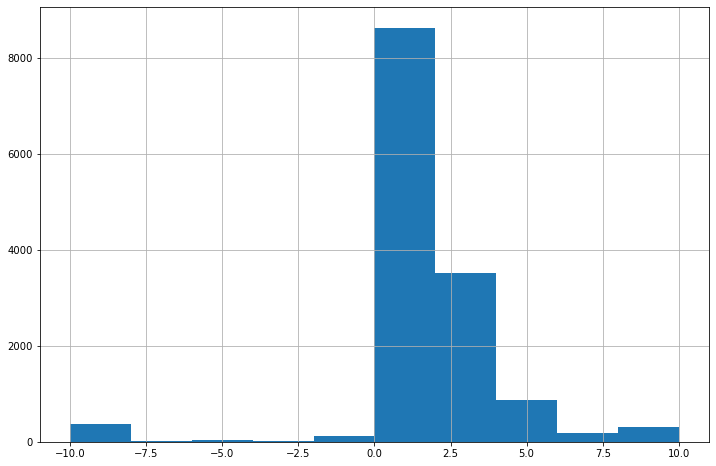

In [39]:
plt.figure(figsize=(12,8))
bi_dir_df['AB_Sent'].hist()

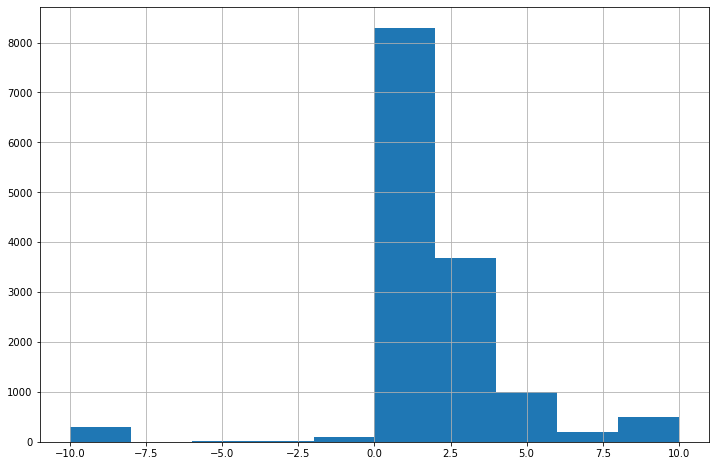

In [40]:
plt.figure(figsize=(12,8))
bi_dir_df['BA_Sent'].hist()

Interestingly, no big difference in the distribution of the ratings compared to the distribution 'overall'. 

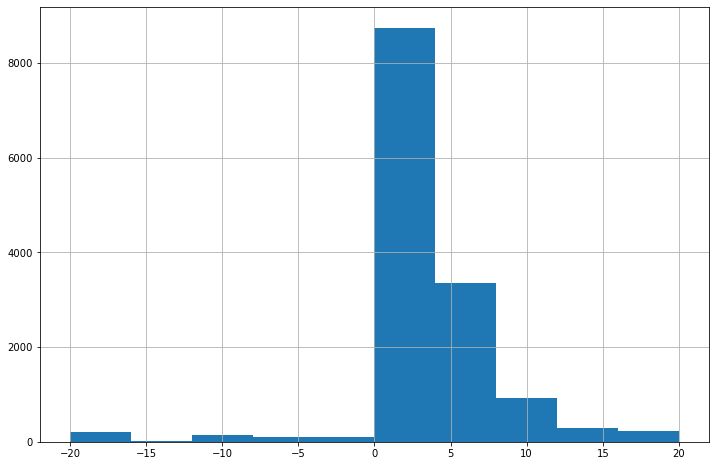

In [41]:
# Let's sum it.
bi_dir_df['Sum'] = bi_dir_df['AB_Sent'] + bi_dir_df['BA_Sent']
plt.figure(figsize=(12,8))
bi_dir_df['Sum'].hist()

It's basically the same. 

In [42]:
# So much about bi-directional queries, but what about triadic relationships? 

tri_query = """
MATCH (a)-[r1:TRUSTS]->(b)-[r2:TRUSTS]->(c)-[r3:TRUSTS]->(a)
WHERE a.id < b.id < c.id
WITH  [a.id, b.id, c.id] AS tuples
RETURN count(tuples)
"""

result = session.run(tri_query).values()

In [43]:
result

[[19469]]

In [44]:
sub_query = """
MATCH (a)-[r1:TRUSTS]->(b)-[r2:TRUSTS]->(c)-[r3:TRUSTS]->(a)
WITH  [a.id, b.id, c.id] AS tuples
RETURN tuples
"""
res = session.run(sub_query).values()

In [45]:
unique_triplets = []

for elem in res:
    if set(elem[0]) not in unique_triplets:
        unique_triplets.append(set(elem[0]))
    else:
        pass

In [46]:
len(unique_triplets)

24829

In [47]:
# A few more relationships, but let's investigate further

In [48]:
query = """
MATCH (a)-[r1:TRUSTS]->(b)-[r2:TRUSTS]->(c)-[r3:TRUSTS]->(a)
WHERE a.id < b.id < c.id
RETURN a.id, b.id, c.id, r1.rating, r2.rating, r3.rating
"""

result = session.run(query).values()

In [49]:
tri_dir_df = pd.DataFrame(result)
tri_dir_df.columns = ['A', 'B', 'C', 'AB_Sent', 'BC_Sent', 'CA_Sent']
tri_dir_df

,A,B,C,AB_Sent,BC_Sent,CA_Sent
0,13,2,744,2,1,1
1,1,2,41,8,2,8
2,10,2,41,7,2,4
3,13,2,41,2,2,3
4,110,2,41,1,2,1
...,...,...,...,...,...,...
19464,4205,5950,5951,1,4,1
19465,4205,5955,5958,3,10,2
19466,5943,5955,5958,3,10,3
19467,1810,5965,5983,1,1,4


(array([9.180e+02, 4.000e+00, 0.000e+00, 5.000e+00, 5.000e+00, 4.900e+01,
        8.000e+00, 2.200e+01, 6.600e+01, 1.620e+02, 0.000e+00, 8.643e+03,
        3.422e+03, 2.248e+03, 9.910e+02, 1.101e+03, 4.360e+02, 2.850e+02,
        3.360e+02, 7.680e+02]),
 array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 20 Patch objects>)

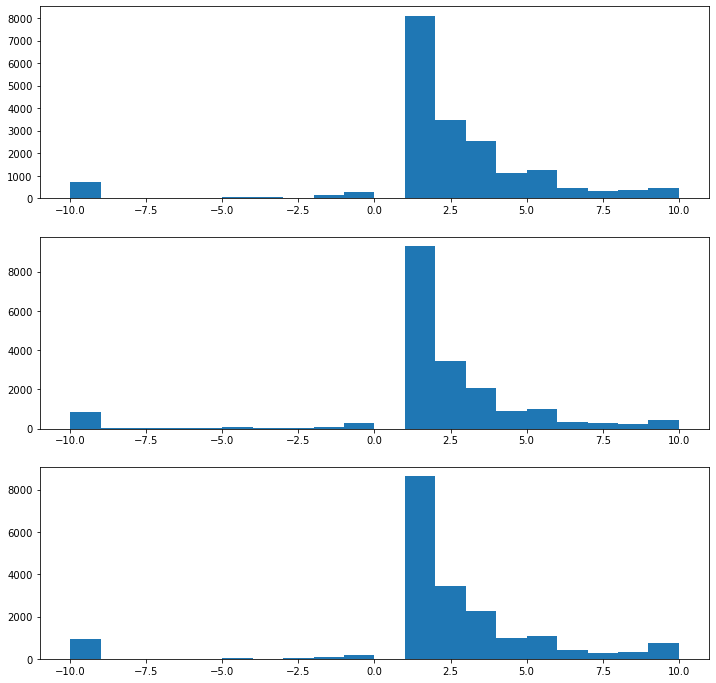

In [50]:
fig, axs = plt.subplots(3,1,figsize=(12,12))
#fig.suptitle('Vertically stacked subplots')
axs[0].hist(tri_dir_df['AB_Sent'], bins=20)
axs[1].hist(tri_dir_df['BC_Sent'], bins=20)
axs[2].hist(tri_dir_df['CA_Sent'], bins=20)

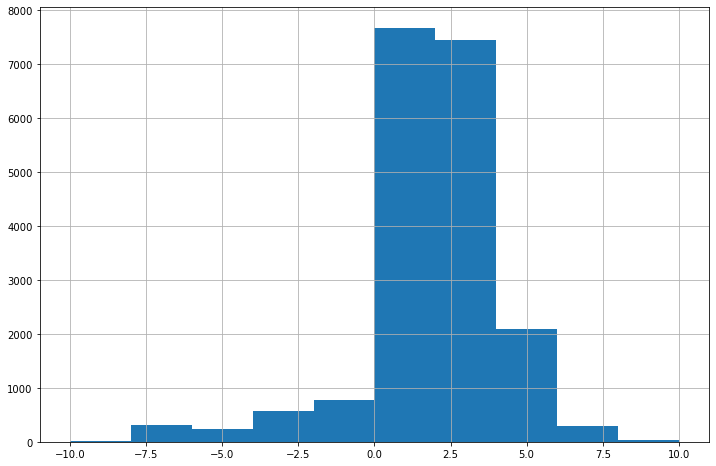

In [51]:
# Summing the sentiment
plt.figure(figsize=(12,8))
tri_dir_df['Sum'] = (tri_dir_df['AB_Sent'] + tri_dir_df['BC_Sent'] + tri_dir_df['CA_Sent']) / 3
tri_dir_df['Sum'].hist()

# 4: Can we find anomalies? 

In [52]:
# Let's start by doing the following: We put the mean rating and the standard deviation 
# of the rating as node properties

query = """
MATCH (p1)-[r:TRUSTS]->(p2)
WITH p2, AVG(r.rating) AS mean_rating, STDEV(r.rating) AS stddev_rating
SET p2.mean_rating = mean_rating
SET p2.stddev_rating = stddev_rating
"""

results = session.run(query)

In [53]:
# Done. Now, let's look at the following. We look at two nodes that both rate each other 
# where the rating given is larger than 1.64 times the standard deviation of the rating given 
# overall. 

query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r21:TRUSTS]->(p1)
WHERE p1.id < p2.id
AND p1.mean_rating < 0 AND p2.mean_rating < 0 
AND r12.rating > p2.mean_rating + 1.64 * p2.stddev_rating
AND r21.rating > p1.mean_rating + 1.64 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r21.rating AS p2_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating
"""

results = session.run(query).data()
pd.DataFrame(results)

,p1,p1_meanRating,p2_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating
0,3744,-8.333333,10,3756,-6.190476,10
1,3744,-8.333333,10,3759,-7.500000,10
2,3744,-8.333333,10,3760,-8.823529,10
3,3756,-6.190476,10,3757,-6.190476,10
4,4678,-7.800000,1,4682,-7.800000,1
5,4678,-7.800000,1,4681,-8.000000,1
6,4678,-7.800000,1,4679,-7.904762,1
7,4679,-7.904762,1,4682,-7.800000,1
8,4679,-7.904762,1,4680,-7.904762,1
9,4679,-7.904762,1,4681,-8.000000,1


In [54]:
# Let's check with 1.96 instead

query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r21:TRUSTS]->(p1)
WHERE r12.rating > p2.mean_rating + 1.96 * p2.stddev_rating
AND r21.rating > p1.mean_rating + 1.96 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r21.rating AS p2_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating
"""

results = session.run(query).data()
pd.DataFrame(results)

,p1,p1_meanRating,p2_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating
0,1,3.544248,10,4,3.111111,10
1,1,3.544248,10,353,1.647059,5
2,2,3.000000,8,198,1.540000,5
3,4,3.111111,10,1,3.544248,10
4,4,3.111111,8,13,1.785340,8
...,...,...,...,...,...,...
221,5403,1.541667,4,4611,1.861111,8
222,5411,3.000000,10,4649,2.028986,10
223,5449,1.900000,5,3804,1.972222,5
224,5591,1.812500,7,2397,1.837209,7


In [55]:
# Let's do it with 2.56

query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r21:TRUSTS]->(p1)
// WHERE p2.mean_rating < 0 AND p1.mean_rating < 0
WHERE r12.rating > p2.mean_rating + 2.56 * p2.stddev_rating
AND r21.rating > p1.mean_rating + 2.56 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r21.rating AS p2_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating
"""

results = session.run(query).data()

In [56]:
pd.DataFrame(results)

,p1,p1_meanRating,p2_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating
0,7,2.842593,10,132,1.687500,5
1,13,1.785340,6,353,1.647059,6
2,64,1.768116,10,1094,1.620690,10
3,113,1.750000,7,468,1.983051,7
4,132,1.687500,5,7,2.842593,10
...,...,...,...,...,...,...
65,4611,1.861111,9,4833,1.962963,9
66,4833,1.962963,9,4611,1.861111,9
67,4852,1.900000,7,353,1.647059,7
68,4884,1.882353,8,4320,1.645161,6


# What about non-direct relationships but 'three hops away' or triadic relationships? 

In [57]:
# Just put properties

query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r23:TRUSTS]->(p3)-[r31:TRUSTS]->(p1)
WHERE p1.id <> p2.id AND p1.id <> p3.id
AND p1.mean_rating < 0 AND p2.mean_rating < 0 AND p3.mean_rating < 0
AND r12.rating > p2.mean_rating + 1.96 * p2.stddev_rating
AND r23.rating > p3.mean_rating + 1.96 * p3.stddev_rating
AND r31.rating > p1.mean_rating + 1.96 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r31.rating AS p3_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating,
       p3.id AS p3, p3.mean_rating AS p3_meanRating, r23.rating AS p_2_to_3_rating
"""

results = session.run(query).data()

In [58]:
pd.DataFrame(results)

,p1,p1_meanRating,p3_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating,p3,p3_meanRating,p_2_to_3_rating
0,3756,-6.190476,10,3744,-8.333333,10,3757,-6.190476,10
1,3756,-6.190476,10,3744,-8.333333,10,3759,-7.500000,10
2,3759,-7.500000,10,3744,-8.333333,10,3760,-8.823529,10
3,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10
4,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10
5,3759,-7.500000,10,3756,-6.190476,10,3744,-8.333333,10
6,3760,-8.823529,10,3756,-6.190476,10,3744,-8.333333,10
7,3744,-8.333333,10,3757,-6.190476,10,3756,-6.190476,10
8,3744,-8.333333,10,3759,-7.500000,10,3756,-6.190476,10
9,3760,-8.823529,10,3759,-7.500000,10,3744,-8.333333,10


# What about four hops away? Layering it further

In [59]:
query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r23:TRUSTS]->(p3)-[r34:TRUSTS]->(p4)-[r41:TRUSTS]->(p1)
WHERE p1.id <> p2.id AND p1.id <> p3.id AND p1.id <> p4.id
AND p2.id <> p4.id AND p2.id <> p3.id AND p2.id <> p4.id
AND p3.id <> p4.id

AND p1.mean_rating < 0 AND p2.mean_rating < 0 AND p3.mean_rating < 0 AND p4.mean_rating < 0
AND r12.rating > p2.mean_rating + 1.96 * p2.stddev_rating
AND r23.rating > p3.mean_rating + 1.96 * p3.stddev_rating
AND r34.rating > p4.mean_rating + 1.96 * p4.stddev_rating
AND r41.rating > p1.mean_rating + 1.96 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r41.rating AS p4_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating,
       p3.id AS p3, p3.mean_rating AS p3_meanRating, r23.rating AS p2_to_p3_rating,
       p4.id AS p4, p4.mean_rating AS p4_meanRating, r34.rating AS p3_to_p4_rating
"""

results = session.run(query).data()
pd.DataFrame(results)

,p1,p1_meanRating,p4_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating,p3,p3_meanRating,p2_to_p3_rating,p4,p4_meanRating,p3_to_p4_rating
0,3760,-8.823529,10,3759,-7.500000,10,3756,-6.190476,10,3744,-8.333333,10
1,3759,-7.500000,10,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10
2,3760,-8.823529,10,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10
3,3744,-8.333333,10,3760,-8.823529,10,3759,-7.500000,10,3756,-6.190476,10
4,3744,-8.333333,10,3760,-8.823529,10,3757,-6.190476,10,3756,-6.190476,10
5,3744,-8.333333,10,3759,-7.500000,10,3757,-6.190476,10,3756,-6.190476,10
6,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10,3757,-6.190476,10
7,3756,-6.190476,10,3744,-8.333333,10,3759,-7.500000,10,3757,-6.190476,10
8,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10,3759,-7.500000,10
9,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10,3759,-7.500000,10


In [60]:
query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r23:TRUSTS]->(p3)-[r34:TRUSTS]->(p4)-[r45:TRUSTS]->(p5)-[r51:TRUSTS]->(p1)
WHERE p1.id <> p2.id AND p1.id <> p3.id AND p1.id <> p4.id AND p1.id <> p5.id
AND p2.id <> p4.id AND p2.id <> p3.id AND p2.id <> p4.id AND p2.id <> p5.id
AND p3.id <> p4.id AND p3.id <> p5.id
AND p4.id <> p5.id

AND p1.mean_rating < 0 AND p2.mean_rating < 0 AND p3.mean_rating < 0 AND p4.mean_rating < 0 AND p5.mean_rating < 0
AND r12.rating > p2.mean_rating + 1.96 * p2.stddev_rating
AND r23.rating > p3.mean_rating + 1.96 * p3.stddev_rating
AND r34.rating > p4.mean_rating + 1.96 * p4.stddev_rating
AND r45.rating > p5.mean_rating + 1.96 * p5.stddev_rating
AND r51.rating > p1.mean_rating + 1.96 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r51.rating AS p5_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating,
       p3.id AS p3, p3.mean_rating AS p3_meanRating, r23.rating AS p2_to_p3_rating,
       p4.id AS p4, p4.mean_rating AS p4_meanRating, r34.rating AS p3_to_p4_rating,
       p5.id AS p5, p5.mean_rating AS p5_meanRating, r45.rating AS p4_to_p5_rating
"""

results = session.run(query).data()
pd.DataFrame(results)

,p1,p1_meanRating,p5_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating,p3,p3_meanRating,p2_to_p3_rating,p4,p4_meanRating,p3_to_p4_rating,p5,p5_meanRating,p4_to_p5_rating
0,3759,-7.500000,10,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10
1,3760,-8.823529,10,3759,-7.500000,10,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10
2,3744,-8.333333,10,3760,-8.823529,10,3759,-7.500000,10,3757,-6.190476,10,3756,-6.190476,10
3,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10,3759,-7.500000,10,3757,-6.190476,10
4,3757,-6.190476,10,3756,-6.190476,10,3744,-8.333333,10,3760,-8.823529,10,3759,-7.500000,10


In [62]:
query = """
MATCH (p1)-[r12:TRUSTS]->(p2)-[r21:TRUSTS]->(p1)
WHERE p2.mean_rating > 0 AND p1.mean_rating > 0
AND r12.rating < p2.mean_rating - 1.96 * p2.stddev_rating
AND r21.rating < p1.mean_rating - 1.96 * p1.stddev_rating
RETURN p1.id AS p1, p1.mean_rating AS p1_meanRating, r21.rating AS p2_to_p1_rating, 
       p2.id AS p2, p2.mean_rating AS p2_meanRating, r12.rating AS p1_to_p2_rating
"""

results = session.run(query).data()

In [63]:
pd.DataFrame(results)

,p1,p1_meanRating,p2_to_p1_rating,p2,p2_meanRating,p1_to_p2_rating
0,13,1.785340,-10,1352,1.618644,-10
1,135,0.301075,-10,3545,1.875000,-8
2,309,0.882353,-10,1675,1.351852,-5
3,710,0.869565,-10,2158,0.666667,-10
4,1352,1.618644,-10,2344,0.913043,-10
5,1352,1.618644,-10,13,1.785340,-10
6,1352,1.618644,-10,1566,2.591837,-10
7,1566,2.591837,-10,1352,1.618644,-10
8,1675,1.351852,-5,309,0.882353,-10
9,1765,1.466667,-3,2067,1.683761,-10


# Rating Prediction

In [134]:
# Use July 2013 as cut-off

In [65]:
query = """
MATCH (a)-[r:TRUSTS]->(b)
WHERE r.time < 1372636800
MERGE (a)-[:EARLY_TRUST {rating: r.rating}]->(b)
"""

display(session.run(query).consume().counters)

query = """
MATCH (a)-[r:TRUSTS]->(b)
WHERE r.time >= 1372636800
MERGE (a)-[:LATE_TRUST {rating: r.rating}]->(b)
"""

display(session.run(query).consume().counters)

{'relationships_created': 24322, 'properties_set': 24322}

{'relationships_created': 11270, 'properties_set': 11270}

In [66]:
query = """
MATCH (a)-[r:EARLY_TRUST]->(b)
RETURN a.id, b.id, r.rating AS rating
"""

train_df = pd.DataFrame([dict(record) for record in session.run(query)])

In [67]:
train_df

,a.id,b.id,rating
0,1,1815,2
1,1,353,5
2,1,33,7
3,1,6,8
4,1,141,1
...,...,...,...
24317,4495,4496,1
24318,4496,4495,1
24319,4497,4402,2
24320,4499,4400,10


In [68]:
query = """
MATCH (a)-[r:LATE_TRUST]->(b)
RETURN a.id, b.id, r.rating AS rating
"""

test_df = pd.DataFrame([dict(record) for record in session.run(query)])
test_df

,a.id,b.id,rating
0,1,4857,2
1,1,905,-5
2,1,3527,2
3,1,2067,1
4,1,202,1
...,...,...,...
11265,5994,5458,1
11266,5995,35,1
11267,5996,5949,3
11268,5999,3878,8


In [69]:
def linkprediction_features(data):
    query = """
    UNWIND $AB as ab
    MATCH (a) WHERE a.id = ab.nodeA
    MATCH (b) WHERE b.id = ab.nodeB
    RETURN a.id AS nodeA, b.id AS nodeB,
        gds.alpha.linkprediction.commonNeighbors(a,b, {relationshipQuery: "EARLY_TRUST", direction: "BOTH"}) AS CN,
        gds.alpha.linkprediction.adamicAdar(a,b, {relationshipQuery: "EARLY_TRUST", direction: "BOTH"}) as AA,
        gds.alpha.linkprediction.resourceAllocation(a,b, {relationshipQuery: "EARLY_TRUST", direction: "BOTH"}) as RA
    """
    
    AB = [{"nodeA": elem[0], "nodeB": elem[1]} for elem in data.values]
    params = {"AB": AB}
    
    features = session.run(query, params).values()
    return features

In [70]:
features5k = pd.DataFrame(linkprediction_features(train_df[:5000]))
features10k = pd.DataFrame(linkprediction_features(train_df[5000:10000]))
features15k = pd.DataFrame(linkprediction_features(train_df[10000:15000]))
features20k = pd.DataFrame(linkprediction_features(train_df[15000:20000]))
features25k = pd.DataFrame(linkprediction_features(train_df[20000:]))

In [71]:
train_features = pd.concat([features5k, features10k, features15k, features20k, features25k])

In [72]:
train_features.columns = ['a.id', 'b.id', 'CN', 'AA', 'RA']

In [73]:
train_features

,a.id,b.id,CN,AA,RA
0,1,1815,7.0,1.474352,0.074539
1,1,353,26.0,6.064763,0.470397
2,1,33,2.0,0.386101,0.013272
3,1,6,24.0,6.397270,0.770571
4,1,141,5.0,1.151791,0.082213
...,...,...,...,...,...
4317,4495,4496,0.0,0.000000,0.000000
4318,4496,4495,0.0,0.000000,0.000000
4319,4497,4402,0.0,0.000000,0.000000
4320,4499,4400,0.0,0.000000,0.000000


In [74]:
trainset = train_df.merge(on=['a.id', 'b.id'], right =train_features)

In [75]:
test_features6k = pd.DataFrame(linkprediction_features(test_df[:6000]))
test_features12k = pd.DataFrame(linkprediction_features(test_df[6000:]))

In [76]:
test_features = pd.concat([test_features6k, test_features12k])
test_features.columns = ['a.id', 'b.id', 'CN', 'AA', 'RA']

In [77]:
testset = test_df.merge(on=['a.id', 'b.id'], right = test_features)

In [78]:
cumsum_early_ratings = node_network[node_network['TIME'] < 1372636800].groupby('TARGET').sum()['RATING']

In [79]:
def early_rating(elem):
    elem = float(elem)
    try:
        val = cumsum_early_ratings.loc[elem]
    except:
        val = 0
    
    return val

In [80]:
trainset['A_EarlyRating'] = trainset['a.id'].apply(early_rating)
trainset['B_EarlyRating'] = trainset['b.id'].apply(early_rating)

testset['A_EarlyRating'] = testset['a.id'].apply(early_rating)
testset['B_EarlyRating'] = testset['b.id'].apply(early_rating)


In [81]:
trainset

,a.id,b.id,rating,CN,AA,RA,A_EarlyRating,B_EarlyRating
0,1,1815,2,7.0,1.474352,0.074539,660,24
1,1,353,5,26.0,6.064763,0.470397,660,104
2,1,33,7,2.0,0.386101,0.013272,660,15
3,1,6,8,24.0,6.397270,0.770571,660,91
4,1,141,1,5.0,1.151791,0.082213,660,30
...,...,...,...,...,...,...,...,...
24317,4495,4496,1,0.0,0.000000,0.000000,1,1
24318,4496,4495,1,0.0,0.000000,0.000000,1,1
24319,4497,4402,2,0.0,0.000000,0.000000,2,28
24320,4499,4400,10,0.0,0.000000,0.000000,1,17


In [111]:
X_train = np.array(trainset.drop(['a.id', 'b.id', 'rating'], axis=1))
y_train = np.array(trainset['rating'])

X_test = np.array(testset.drop(['a.id', 'b.id', 'rating'], axis=1))
y_test = np.array(testset['rating'])

In [135]:
from sklearn.linear_model import LinearRegression

In [113]:
reg = LinearRegression().fit(X_train, y_train)

In [114]:
reg.score(X_train, y_train)

0.04620431876644959

In [115]:
reg.coef_

array([-1.60594594e-01,  1.21506967e+00, -4.56389252e+00, -1.80021016e-05,
        3.26418336e-03])

In [116]:
reg.intercept_

1.0223543164198527

In [118]:
predictions = reg.predict(np.array(X_test))

In [119]:
predictions

array([1.01047293, 4.05905096, 1.11819098, ..., 1.02235432, 1.08763798,
       1.02235432])

In [120]:
from sklearn.metrics import mean_squared_error

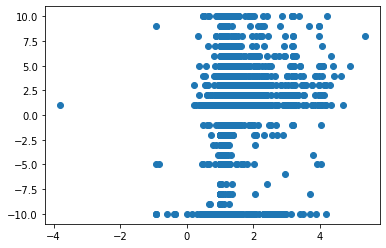

In [122]:
plt.scatter(predictions, y_test)

In [123]:
mean_squared_error(predictions, y_test)

20.032745970802637

In [132]:
# Very poor indeed. How about just taking the mean rating as baseline?  
from itertools import repeat

baseline_prediction = np.array(list(repeat(trainset['rating'].mean(), len(y_test))))
mean_squared_error(baseline_prediction, y_test)

20.664396430089425

In [133]:
# Barely any difference

In conclusion, we have seen how neo4j/cypher can be used for pattern matching and finding anomalies, however, due to the highly skewed nature of the ratings, the rating prediction did not work out as hoped for, as it is hardly any better than a baseline estimate of the mean rating. 